In [93]:
from os import listdir
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np

from matplotlib.mlab import PCA
import matplotlib.cm as cm

from sklearn import neighbors as knn
from sklearn.metrics import confusion_matrix as cm

%matplotlib inline

In [99]:
def plot_confusion_matrix(confmat, labels_names, ax=None):
    pl.figure()
    if ax is None:
        ax = pl.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap='jet')

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=10, color='white')
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in range(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    ax.set_yticklabels([labels_names[l] for l in range(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    pl.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)
    pl.show()

In [2]:
path = "./selected_raw_data/"

## Import data
Steps for each file :
- print filename (useful to access data later)
- create a dataframe from the values inside the file
- clean timestamp in order to get a column indicating the elapsed time in seconds

In [3]:
data = {}
for f in listdir(path):
    print(f)
    data[f] = pd.read_csv(path+f)
    start_time = data[f]["timestamp"][0]
    data[f]["timestamp"] = (data[f]["timestamp"]-start_time)/1000

abdos_f5_lud.csv
abdos_f5_manon1.csv
abdos_f5_manon2.csv
corde_f5_manon1.csv
corde_f5_manon2.csv
dorsaux_f5_lud.csv
dorsaux_f5_manon1.csv
dorsaux_f5_manon2.csv
squats_f5_lud.csv
squats_f5_manon1.csv
squats_f5_manon2.csv


##  Plots
### Abdos

c:\users\ludivine\anaconda2\envs\server\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
c:\users\ludivine\anaconda2\envs\server\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


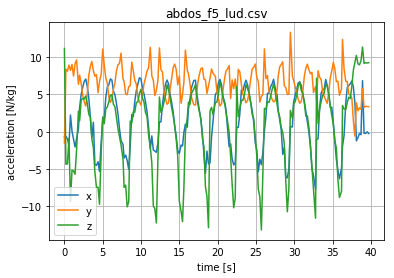

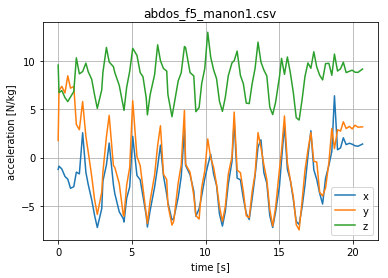

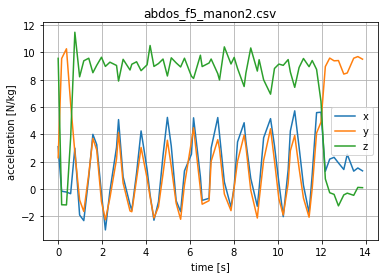

In [4]:
for f in data:
    if "abdos" in f:
        data[f].plot(x="timestamp", y=['x', 'y', 'z'], kind='line', title=f, grid=True)
        pl.ylabel('acceleration [N/kg]')
        pl.xlabel('time [s]')

### Squats

c:\users\ludivine\anaconda2\envs\server\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


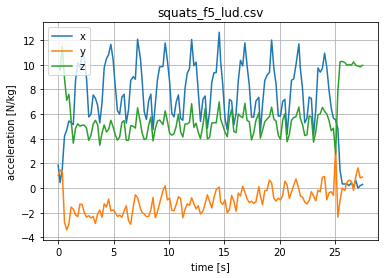

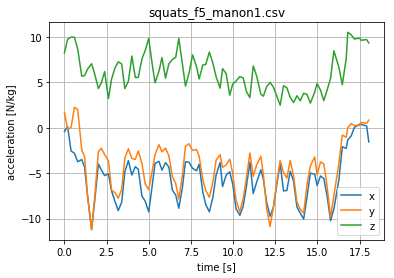

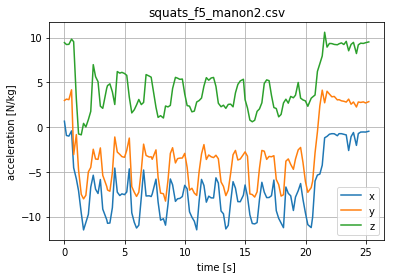

In [5]:
for f in data:
    if "squats" in f:
        data[f].plot(x="timestamp", y=['x', 'y', 'z'], kind='line', title=f, grid=True)
        pl.ylabel('acceleration [N/kg]')
        pl.xlabel('time [s]')

### Dorsaux

c:\users\ludivine\anaconda2\envs\server\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


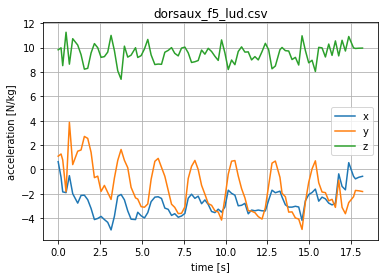

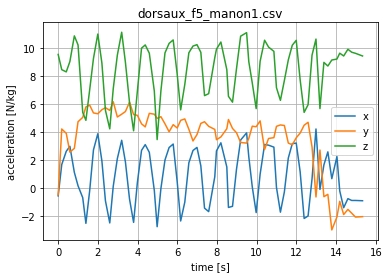

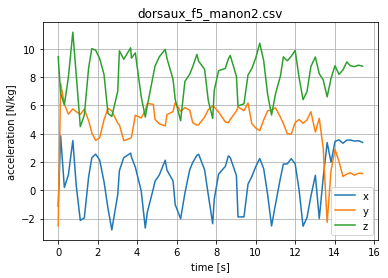

In [6]:
for f in data:
    if "dorsaux" in f:
        data[f].plot(x="timestamp", y=['x', 'y', 'z'], kind='line', title=f, grid=True)
        pl.ylabel('acceleration [N/kg]')
        pl.xlabel('time [s]')

### Sauts à la corde

c:\users\ludivine\anaconda2\envs\server\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


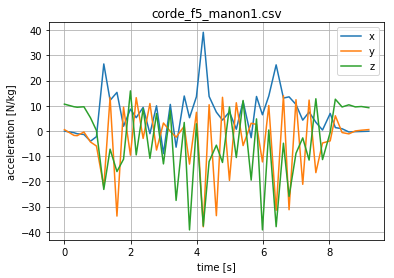

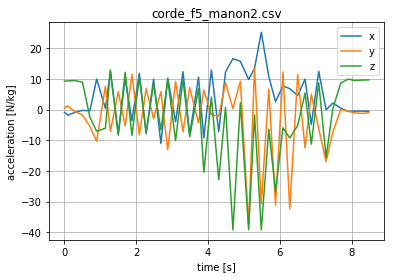

In [7]:
for f in data:
    if "corde" in f:
        data[f].plot(x="timestamp", y=['x', 'y', 'z'], kind='line', title=f, grid=True)
        pl.ylabel('acceleration [N/kg]')
        pl.xlabel('time [s]')

# Slices generation
Découpage des fichiers en tranches de 10 points, ce qui correspond à environ 2 secondes.

Stockage dans un dictionnaire, avec les différents exercices comme clés.

In [105]:
n_samples_per_slice = 10
slice_overlap = 5

storage = {}
for f in data:
    # skip lud data, for the moment we only consider one person
    #if 'lud' in f:
    #    continue
        
    # sort data in the python dict according to type of exercise (found in filename)    
    if 'corde' in f:
        label = 'corde'
    elif 'squats' in f:
        label = 'squats'
    elif 'dorsaux' in f:
        label = 'dorsaux'
    elif 'abdos' in f:
        label = 'abdos'
    
    # iterate through the file too generate slices
    # by starting at "slice_duration", we skip the first slice, which might not be relevant
    # we also drop the last slice by stopping the loop 2*slice duration before the end
    for start_sample in range(n_samples_per_slice, len(data[f]['timestamp'])-2*n_samples_per_slice, slice_overlap):
        df_temp = data[f].iloc[start_sample:start_sample+n_samples_per_slice, :]
        df_temp = df_temp.drop(columns='timestamp')
        
        # TODO: drop first and last slice of each file

        if label in storage.keys():          # if the label already exists in the dictionary
            temp = storage[label]
            temp.append(df_temp)           # append the new geture to the list
            storage[label] = temp
        else:
            storage[label] = [df_temp,] # otherwise, create a list with one element

In [106]:
for label in storage.keys():             # stack the recordings with the same label
    storage[label] = np.dstack(storage[label])
    print('label', label, ':', storage[label].shape[2], 'samples')

# the resulting recordings shape is [n_samples x 6 x n_repetitions]

label abdos : 57 samples
label corde : 7 samples
label dorsaux : 33 samples
label squats : 55 samples


# Compute the features
À partir de là, on entre dans le ML... Tout est repris et adapté à partir du labo 5. On pourra pas la suite être plus créatives et tester d'autres algorithmes de classification

In [107]:
features = {}
for label in storage.keys():
    features[label] = np.mean(storage[label], axis=0).T
    #features[label] = np.std(storage[label], axis=0).T
    #features[label] = np.hstack((np.mean(storage[label], axis=0).T, np.std(storage[label], axis=0).T))
    
# the resulting features shape is [n_repetitions x n_features]

# Compilation of a single dataset
Les données sont séparées en input = features calculées à partir des valeurs retournées par l'accéléromètre de la montre, et output = label de l'exercice

In [108]:
data_input = []
data_output = []
for label in features.keys():
    data_input.append(features[label])
    data_output.append(np.repeat(label, features[label].shape[0]))
data_input = np.vstack(data_input)
data_output = np.hstack(data_output)

# Visualisation with PCA
Si on importe les données de plusieurs personnes ou d'une seule, on voit bien que chaque personne exécute ses mouvements différemment...

In [109]:
results_pca = PCA(data_input)

First two components keep 79.61449914001153 percent of the total variance


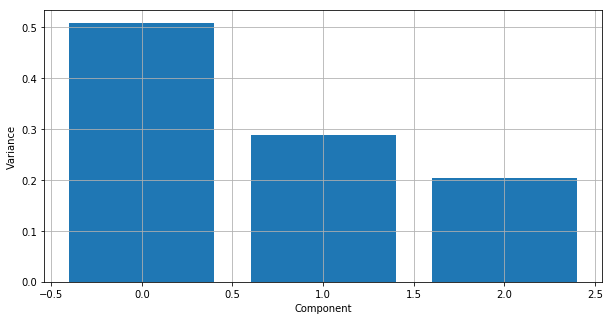

In [110]:
pl.figure(figsize=(10,5))
pl.bar(x=np.arange(len(results_pca.fracs)), height=results_pca.fracs)
pl.ylabel('Variance')
pl.xlabel('Component')
pl.grid()

print('First two components keep', 100*(results_pca.fracs[0] + results_pca.fracs[1]), 'percent of the total variance')

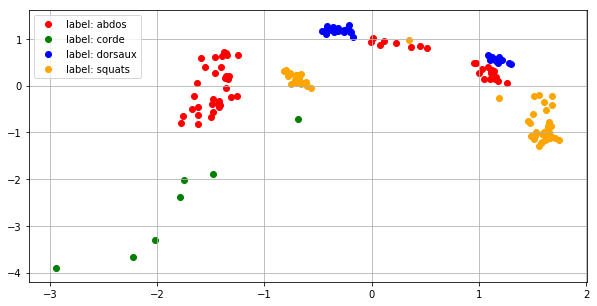

In [111]:
colors = ['red', 'green', 'blue', 'orange', 'magenta', 'cyan']

labels = storage.keys()

pl.figure(figsize=(10,5))
for i,l in enumerate(sorted(labels)):
    this_labels = results_pca.Y[data_output==l,:]
    pl.scatter(this_labels[:,0], this_labels[:,1], c=colors[i], label='label: '+l)
pl.legend()
pl.grid()

# Classification

In [112]:
#convert output values to int
label_dict = {'abdos':1, 'squats':2, 'dorsaux':3, 'corde':4}
data_output_num = -1 * np.ones(len(data_output))
for i, val in enumerate(data_output):
    data_output_num[i] = label_dict[val]

In [113]:
N_NEIGHBORS = 3

# leave-one-out cross-validation:
# given N observations, use N-1 observations to fit the model
# and classify the observation that was not used for fitting
    

model_classification = -1 * np.ones(len(data_output))

for v_index in range(len(data_output)):
    data_input_calib = np.delete(data_input, v_index, axis=0)
    data_input_test = data_input[v_index:v_index+1, :]
    
    data_output_calib = np.delete(data_output_num, v_index)
    data_output_test = data_output_num[v_index]
    
    model = knn.KNeighborsClassifier(N_NEIGHBORS, 'uniform')
#    model = knn.KNeighborsClassifier(N_NEIGHBORS, 'distance')
    model.fit(data_input_calib, data_output_calib)
    
    model_classification[v_index] = model.predict(data_input_test)

# Résultats

In [114]:
# accuracy
acc = 100 * np.sum(model_classification == data_output_num) / len(data_output)
print('accuracy: ', acc, '%')

accuracy:  98.02631578947368 %


In [117]:
# confusion matrix
confusion_matrix = cm(data_output_num, model_classification)

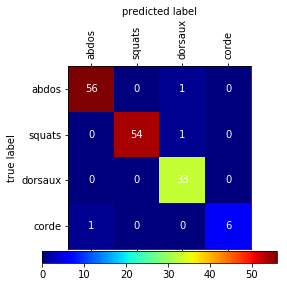

In [118]:
plot_confusion_matrix(confusion_matrix, list(label_dict.keys()))